In [1]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-9-813d39c3ad0f>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/IBeer.ai/beer_classifiations.pth', 

Predicted Beer: Becks Beer


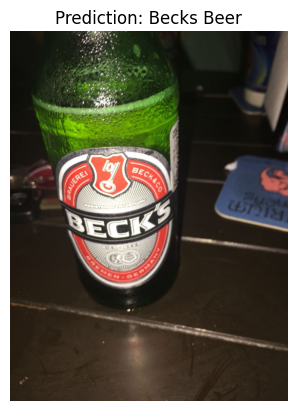

In [9]:
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch.nn as nn

# label mapping (same as used during training)
label_mapping = {
    0: 'Tiger Beer',
    1: 'Asahi Super Dry Beer',
    2: 'Kingfisher Beer',
    3: 'Budweiser Beer',
    4: 'Stella Artois',
    5: 'Becks Beer',
    6: 'Carlsberg Beer',
    7: 'Heineken Beer',
    8: 'Tuborg Beer',
    9: 'Corona Beer'
}

# Define the model class
class BeerModel(nn.Module):
    def __init__(self):
        super(BeerModel, self).__init__()
        self.network = models.vgg16(pretrained=True)

        # Freeze all layers
        for param in self.network.parameters():
            param.requires_grad = False

        # Define new classifier
        self.network.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(25088, 512)),
            ('relu', nn.ReLU()),
            ('dropout', nn.Dropout(0.5)),
            ('fc2', nn.Linear(512, 10)),
            ('output', nn.LogSoftmax(dim=1))
        ]))

    def forward(self, xb):
        return self.network(xb)

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BeerModel().to(device)

# Load the trained model
model.load_state_dict(torch.load('/content/drive/MyDrive/IBeer.ai/beer_classifiations.pth', map_location=device))
model.eval()

# Image transformation (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_image(image_path, model):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Make the prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, dim=1)

    predicted_label = predicted.item()
    beer_name = label_mapping.get(predicted_label, "Unknown Beer")

    return beer_name


image_path = "/content/drive/MyDrive/beerClassification/Becks Beer/Becks (1).jpeg"
predicted_beer = predict_image(image_path, model)
print(f"Predicted Beer: {predicted_beer}")

# display the image and prediction
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Prediction: {predicted_beer}")
plt.axis('off')
plt.show()
